<a href="https://colab.research.google.com/github/larico1599/Forecast_Puno_60kv/blob/master/RNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando librerias



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd #leer archivos excel
import datetime

from sklearn.impute import SimpleImputer

import keras
from keras.models import Sequential
from keras.layers import Dense # crea capas e inicializa pesos con pequeños
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split

## Data Set

In [2]:
dataset = pd.read_excel('./puno_60kv_pre_proc.xlsx', index_col=0, parse_dates=True)
dataset.shape

(128544, 1)

In [3]:
dataset=dataset[0:-1:2]
dataset.shape

(64272, 1)

In [4]:
dataset.head()

,consumo
FECHA,
2018-01-01 00:00:00,3.806495
2018-01-01 00:30:00,3.757220
2018-01-01 01:00:00,3.457277
2018-01-01 01:30:00,2.972107
2018-01-01 02:00:00,2.619474


## Estructura de  los datos de entrada

In [5]:
# Frame 2
# copia de df_1
df_2= dataset.copy()

# Separar día y hora
df_2['fecha'] = df_2.index.normalize()
df_2['hora'] = df_2.index.time.astype(str)
df_2["dia"]=df_2.index.day_name()

df_2.head()

,consumo,fecha,hora,dia
FECHA,,,,
2018-01-01 00:00:00,3.806495,2018-01-01,00:00:00,Monday
2018-01-01 00:30:00,3.757220,2018-01-01,00:30:00,Monday
2018-01-01 01:00:00,3.457277,2018-01-01,01:00:00,Monday
2018-01-01 01:30:00,2.972107,2018-01-01,01:30:00,Monday
2018-01-01 02:00:00,2.619474,2018-01-01,02:00:00,Monday


In [6]:
#Transformando del Dataframe
df_pivot= df_2.pivot(index=['fecha',"dia"], columns='hora', values='consumo')
#copia
df_semanaPasada= df_pivot.copy()
# Eliminar datos 
df_semanaPasada = df_semanaPasada.drop(["2021-08-25","2021-08-26","2021-08-27","2021-08-28","2021-08-29","2021-08-30","2021-08-31","2021-08-24"])
df_semanaPasada.head()

,hora,00:00:00,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,04:30:00,...,19:00:00,19:30:00,20:00:00,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00
fecha,dia,,,,,,,,,,,,,,,,,,,,,
2018-01-01,Monday,3.806495,3.757220,3.457277,2.972107,2.619474,2.420526,2.265926,2.167135,2.120294,2.141302,...,3.882836,4.092023,4.074759,3.941521,3.742466,3.429134,3.163509,2.895145,2.623867,2.473210
2018-01-02,Tuesday,2.311954,2.142135,2.037293,1.971618,1.966999,1.901741,1.893686,1.910216,1.918776,1.936571,...,4.489323,4.638003,4.631736,4.405867,4.161745,3.834614,3.463798,3.079862,2.768906,2.555385
2018-01-03,Wednesday,2.308899,2.161110,2.073152,1.975605,1.963590,1.902332,1.884832,1.897034,1.954657,1.994692,...,4.534983,4.768905,4.720042,4.491115,4.218134,3.833161,3.422813,3.022365,2.739229,2.528028
2018-01-04,Thursday,2.339694,2.151907,2.038640,1.974856,1.896870,1.891731,1.888588,1.848422,1.912317,1.963574,...,4.625531,4.888726,4.903282,4.674095,4.424584,4.067069,3.608998,3.197823,2.869154,2.619535
2018-01-05,Friday,2.376024,2.197770,2.055888,1.990392,1.967032,1.902162,1.893244,1.911412,1.961349,2.033576,...,4.669488,4.838292,4.779548,4.537767,4.305984,3.932174,3.496835,3.134923,2.886157,2.582012


In [7]:
#df de los dias anteriores al pronostico
df_diaAPronosticar= df_pivot.copy()
# df a pronosticar
df_semanaActual = df_pivot.copy()

In [8]:
df_semanaActual = df_semanaActual.drop(["2018-01-01", "2018-01-02","2018-01-03","2018-01-04","2018-01-05","2018-01-06","2018-01-07","2021-08-31"])
df_semanaActual.head()

,hora,00:00:00,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,04:30:00,...,19:00:00,19:30:00,20:00:00,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00
fecha,dia,,,,,,,,,,,,,,,,,,,,,
2018-01-08,Monday,2.255422,2.118422,2.013014,1.916983,1.915596,1.919337,1.870714,1.890034,1.904158,2.000270,...,4.570029,4.752322,4.590838,4.453324,4.194480,3.824362,3.442374,3.088222,2.828520,2.528517
2018-01-09,Tuesday,2.331807,2.171008,2.036886,1.966961,1.940963,1.889964,1.873399,1.914909,1.900971,1.967280,...,4.665177,4.796478,4.746421,4.488145,4.164240,3.775501,3.369526,3.029806,2.739511,2.495486
2018-01-10,Wednesday,2.311075,2.138633,2.031769,2.008956,1.949631,1.964212,1.917286,1.947335,1.952080,2.009601,...,4.638885,4.880087,4.810955,4.593394,4.299870,3.912242,3.556226,3.143431,2.850410,2.595439
2018-01-11,Thursday,2.384005,2.205027,2.097458,1.994480,1.983286,1.915694,1.901747,1.946695,1.960999,2.000147,...,4.750297,4.821373,4.682732,4.430076,4.124015,3.754108,3.368139,3.009790,2.752462,2.498383
2018-01-12,Friday,2.339800,2.173865,2.046821,1.963579,1.952152,1.927200,1.911393,1.916468,1.972693,1.997147,...,4.736800,4.803333,4.658659,4.438990,4.100753,3.697332,3.356100,2.967280,2.766286,2.526506


In [9]:
df_diaAPronosticar = df_diaAPronosticar.drop(["2018-01-01", "2018-01-02","2018-01-03","2018-01-04","2018-01-05","2018-01-06","2018-01-07","2018-01-08"])
df_diaAPronosticar.head()

,hora,00:00:00,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,04:30:00,...,19:00:00,19:30:00,20:00:00,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00
fecha,dia,,,,,,,,,,,,,,,,,,,,,
2018-01-09,Tuesday,2.331807,2.171008,2.036886,1.966961,1.940963,1.889964,1.873399,1.914909,1.900971,1.967280,...,4.665177,4.796478,4.746421,4.488145,4.164240,3.775501,3.369526,3.029806,2.739511,2.495486
2018-01-10,Wednesday,2.311075,2.138633,2.031769,2.008956,1.949631,1.964212,1.917286,1.947335,1.952080,2.009601,...,4.638885,4.880087,4.810955,4.593394,4.299870,3.912242,3.556226,3.143431,2.850410,2.595439
2018-01-11,Thursday,2.384005,2.205027,2.097458,1.994480,1.983286,1.915694,1.901747,1.946695,1.960999,2.000147,...,4.750297,4.821373,4.682732,4.430076,4.124015,3.754108,3.368139,3.009790,2.752462,2.498383
2018-01-12,Friday,2.339800,2.173865,2.046821,1.963579,1.952152,1.927200,1.911393,1.916468,1.972693,1.997147,...,4.736800,4.803333,4.658659,4.438990,4.100753,3.697332,3.356100,2.967280,2.766286,2.526506
2018-01-13,Saturday,2.324390,2.183835,2.065366,1.989065,1.979599,1.915899,1.895047,1.910258,1.927004,1.968931,...,4.367794,4.562541,4.477814,4.299726,3.990014,3.668393,3.346010,2.994830,2.735055,2.518101


In [10]:
# Dimensiones 
df_semanaActual.values.shape, df_semanaPasada.values.shape

((1331, 48), (1331, 48))

In [11]:
# Concatenar array df_semanaActual con  df_semanaPasada
X = np.concatenate((df_semanaActual,df_semanaPasada),axis=1 )
y = df_diaAPronosticar.values
X.shape, y.shape

((1331, 96), (1331, 48))

In [12]:
# Dividir el conjunto en entrenamiento y prueba
X_train = X[0:1087,:]
y_train = y[0:1087,:] 

X_test = X[1088:,:]
y_test = y[1088:,:]

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((1087, 96), (1087, 48), (243, 96), (243, 48))

## Red Neuronal

In [13]:
# Construir el modelo
def build_model_regression(input_data):
    model = models.Sequential()
    model.add(layers.Dense(10,activation='relu',input_shape=(input_data,)))
    model.add(layers.Dense(10,activation='relu'))
    model.add(layers.Dense(48))
    model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])

    return model

In [14]:
# K-Fold Validation : Iterar sobre el conjunto de entrenamiento el conjunto de validacion, la validacion ira cambiando
k = 4
num_val_samples = len(X_train) // k 
num_epoch = 500
all_history = []

In [15]:
# 4 distintos entrenamientos con el set de validacion en una posicion distinta
for i in range(k):
    print("Fold " , i)
                        # 0:1*271 ; 271:2*271 ; 2*271:3*271; ......
    val_data = X_train[i*num_val_samples: (i+1) * num_val_samples]
    val_targets = y_train[i*num_val_samples: (i+1) * num_val_samples]
    # El data set se divide en 4 partes para el entramiento utiliza los 4 y para la validacion solo 1
    partial_train_data = np.concatenate(
    [X_train[:i * num_val_samples],# 0; 1*271; ....
     X_train[(i+1) * num_val_samples:]], # 271;2*271;.... 
     axis= 0   
    )
    
    partial_train_targets = np.concatenate(
    [y_train[:i * num_val_samples],
     y_train[(i+1) * num_val_samples:]],
     axis= 0   
    ) 
    # modelo
    model = build_model_regression(96)
    history = model.fit(partial_train_data.astype('float32')  , partial_train_targets.astype('float32') , epochs=num_epoch, batch_size =16, 
                        validation_data = (val_data, val_targets),
                        verbose=0)
    
    all_history.append(history.history['val_mae'])

Fold  0
Fold  1
Fold  2
Fold  3


In [16]:
# Resultado de las 4 iteraciones en las 500 epocas
pd.DataFrame(all_history)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.813083,0.892428,0.285868,0.161307,0.191811,0.185540,0.156452,0.160151,0.173783,0.175613,...,0.125553,0.120908,0.120522,0.121008,0.154127,0.119258,0.126095,0.125387,0.120357,0.124309
1,1.914591,1.068727,0.522009,0.263934,0.189247,0.151555,0.166388,0.146523,0.144576,0.144759,...,0.119088,0.131379,0.120468,0.122369,0.121094,0.121204,0.124031,0.122698,0.128188,0.120268
2,1.645944,0.763140,0.356099,0.180883,0.155738,0.159201,0.170619,0.167492,0.174429,0.160592,...,0.117911,0.117266,0.123616,0.121608,0.119611,0.117243,0.122610,0.125350,0.128212,0.133080
3,1.445354,0.568108,0.148002,0.156052,0.177182,0.172413,0.129815,0.165540,0.152288,0.185855,...,0.121297,0.131350,0.128486,0.116582,0.110725,0.116068,0.157478,0.120425,0.125914,0.102885


In [17]:
# promedio del error absoluto medio 
all_mae_avg = pd.DataFrame(all_history).mean(axis=0)
all_mae_avg

0      1.704743
1      0.823101
2      0.327994
3      0.190544
4      0.178494
         ...   
495    0.118443
496    0.132554
497    0.123465
498    0.125668
499    0.120135
Length: 500, dtype: float64

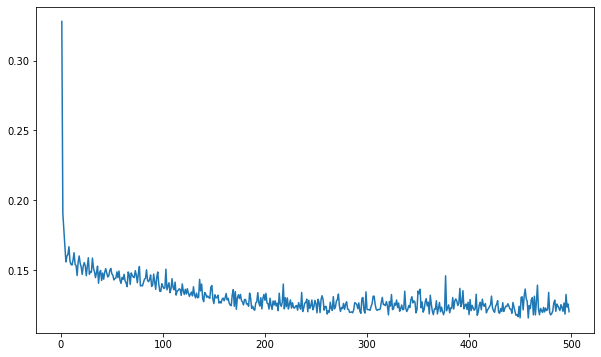

In [18]:
# Grafica epocas vs mean absolute erro
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(range(1,len(all_mae_avg[2:])+1), all_mae_avg[2:])
plt.show()

In [19]:
#model.evaluate(test_data, test_targets)
model.evaluate(X_train, y_train) #desviacion de 0.11 

34/34 [==============================] - 0s 2ms/step - loss: 0.0248 - mae: 0.1165


[0.024776721373200417, 0.1164923757314682]

In [21]:
#Predicciones
def predict(X_test,y_test,model):
  predictions = []
  for i in range(len(X_test)):
    predictions.append(model.predict(X_test[i:i+1:]))
  return predictions

In [22]:
#array de fechas  de test
date = np.array([dataset["2021"].index])
date=date.reshape(date.shape[1])
def newData(predict,test):
  #reshape predictions y test
  predict = predict.reshape(243*48,1)
  test = test.reshape(243*48,1)

  # matriz de tests y predictions_two
  data = np.concatenate((test,predict),axis=1)

  # dataframe con test y predictions
  df = pd.DataFrame(data=data, index=date,columns=["test","predictions"])

  return df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


In [23]:
#mape
def mape(test,predict):
  #reshape test
  #test = test.reshape(test.shape[0],test.shape[1]*test.shape[2] )
  #mape
  mape = np.mean(np.abs((test-predict)/test))*100
  return mape

In [24]:
# calculo del MAPE por dias
def mapePerDays(df,MAPE_GLOBAL):
  # agregar dias al df
  df["day"]= df.index.day_name()
  #df por dias
  df_monday = df[df["day"] == "Monday"]
  df_tuesday = df[df["day"] == "Tuesday"]
  df_wednesday = df[df["day"] == "Wednesday"]
  df_thursday = df[df["day"]=="Thursday"]
  df_friday = df[df["day"] == "Friday"]
  df_saturday = df[df["day"] == "Saturday"]
  df_sunday = df[df["day"] == "Sunday"]

  #calculo del mape por dias
  monday_mape = mape(df_monday["test"].values,df_monday["predictions"].values)
  tuesday_mape = mape(df_tuesday["test"].values,df_tuesday["predictions"].values)   
  wednesday_mape = mape(df_wednesday["test"].values,df_wednesday["predictions"].values)   
  thursday_mape = mape(df_thursday["test"].values,df_thursday["predictions"].values)   
  friday_mape = mape(df_friday["test"].values,df_friday["predictions"].values)   
  saturday_mape = mape(df_saturday["test"].values,df_saturday["predictions"].values)   
  sunday_mape = mape(df_sunday["test"].values,df_sunday["predictions"].values)   
  
  return [monday_mape, tuesday_mape,wednesday_mape,thursday_mape,friday_mape,saturday_mape,sunday_mape,MAPE_GLOBAL]

In [25]:
#Predicciones desde enero hasta agosto del 2021
predictions = predict(X_test, y_test,model)

In [26]:
df_resultados = newData(np.array(predictions),y_test)

In [27]:
#dataframe de test vs predicciones
df_resultados.head()

,test,predictions
2021-01-01 00:00:00,3.730907,2.665803
2021-01-01 00:30:00,3.679624,2.488494
2021-01-01 01:00:00,3.336446,2.345039
2021-01-01 01:30:00,2.985824,2.265343
2021-01-01 02:00:00,2.712038,2.145049


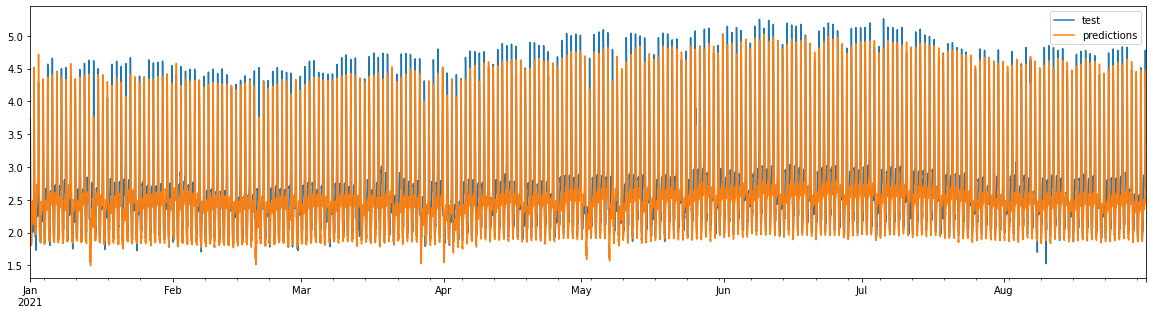

In [32]:
#Resultado de las predicciones
df_resultados.plot(figsize=(20,5))

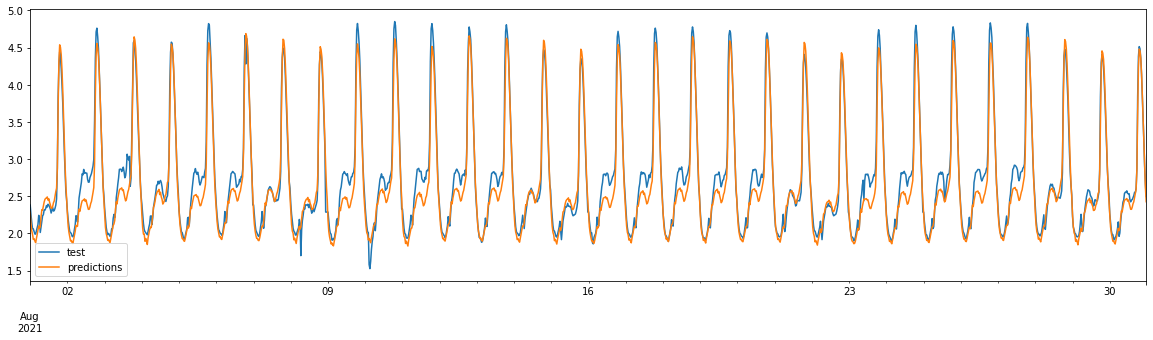

In [33]:
#Predicciones para una mes
df_resultados.loc["2021-08-01":"2021-08-30"].plot(figsize=(20,5))

##MAPE
Cálculo del mape general

In [29]:
mapeGeneral = mape(df_resultados["test"].values, df_resultados["predictions"].values)   
print(f'{mapeGeneral.round(2)} %')

5.28 %


In [30]:
dias = ["Lunes","Martes","Miercoles","Jueves","Viernes","Sabado","Domingo","Global"]

In [31]:
#calcula el MAPE  por dias
listMape = mapePerDays(df_resultados,mapeGeneral)
#df 
df_mape = pd.DataFrame(data=listMape,columns=["MAPE"] ,index=dias )
df_mape.round(2)

,MAPE
Lunes,5.94
Martes,4.85
Miercoles,5.00
Jueves,5.68
Viernes,5.90
Sabado,4.90
Domingo,4.71
Global,5.28


##Guardar el Modelo


In [37]:
model.save('./models/RNA.h5')


##Cargar un modelo

In [38]:
#new_model = load_model('RNA.h5')
#new_model.summary()
